In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df_copy = df.copy()
df_copy = pd.get_dummies(df_copy, columns=['sex', 'smoker', 'region'], drop_first=True)
df_copy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Applied one-hot encoding to convert categorical features into numeric values.

In [4]:
#In the other ipynb file we see bmi some outliers exist. We can handle them if necessary.
Q1 = df_copy['bmi'].quantile(0.25)
Q3 = df_copy['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
len(df_copy[(df_copy['bmi'] < lower_bound) | (df_copy['bmi'] > upper_bound)])
#so there is only 9 outliers in bmi column. We can remove them.
df_copy = df_copy[(df_copy['bmi'] >= lower_bound) & (df_copy['bmi'] <= upper_bound)]
df_copy.shape

(1329, 9)

Removed outliers from the 'bmi' column to improve data quality. Because we know from other notebooks there were outliers

In [5]:
from sklearn.model_selection import train_test_split
X = df_copy.drop('charges', axis=1)
y = df_copy['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Split the processed data into training and testing sets.

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


In [7]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train,y_train)
y_pred = tree_model.predict(X_test)

Trained the baseline Decision Tree model and generated predictions.

In [8]:
mae_tree = mean_absolute_error(y_test, y_pred)
mse_tree = mean_squared_error(y_test, y_pred)
r2_tree = r2_score(y_test, y_pred)
print(f"Decision Tree MAE: {mae_tree}")
print(f"Decision Tree MSE: {mse_tree}")
print(f"Decision Tree R2 Score: {r2_tree}")
adjusted_r2_tree = 1 - ( 1-r2_tree ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )
print(f'Decision Tree Adjusted R2: {adjusted_r2_tree}')

Decision Tree MAE: 3209.4204918168166
Decision Tree MSE: 44226241.986184634
Decision Tree R2 Score: 0.679933051131949
Decision Tree Adjusted R2: 0.6720301635055774


Evaluation of the baseline model using MAE, MSE, and R2 scores.

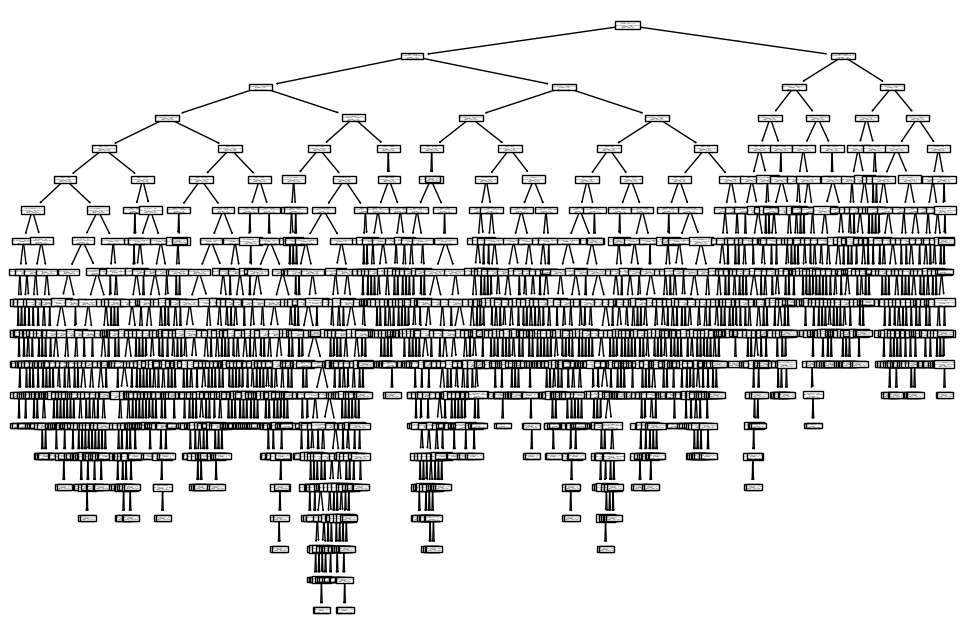

In [9]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(tree_model.fit(X_train, y_train), feature_names=X_train.columns)
plt.show()

Our model R2 score is 0.67 and it's tree is very long let's do hyperparameter tuning

In [10]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [3, 5, 7, 10, 15, None],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None,  'sqrt', 'log2']
}


Defined the parameter grid for hyperparameter optimization.

In [11]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

Initialized GridSearchCV to find the most effective tree parameters.

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [3, 5, 7, 10, 15, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='r2')

Executed the grid search on the training data.

In [13]:
grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'best'}

In [14]:
grid.best_score_

np.float64(0.8395925693768529)

Checked the best R2 score achieved during optimization.

In [15]:
y_pred_grid = grid.predict(X_test)
mae_tree_grid = mean_absolute_error(y_test, y_pred_grid)
mse_tree_grid = mean_squared_error(y_test, y_pred_grid)
r2_tree_grid = r2_score(y_test, y_pred_grid)
print(f"Decision Tree (Grid Search) MAE: {mae_tree_grid}")
print(f"Decision Tree (Grid Search) MSE: {mse_tree_grid}")
print(f"Decision Tree (Grid Search) R2 Score: {r2_tree_grid}")
adjusted_r2_tree_grid = 1 - ( 1-r2_tree_grid ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )
print(f'Decision Tree (Grid Search) Adjusted R2: {adjusted_r2_tree_grid}')

Decision Tree (Grid Search) MAE: 1747.209169129129
Decision Tree (Grid Search) MSE: 17608159.652881835
Decision Tree (Grid Search) R2 Score: 0.8725690973915461
Decision Tree (Grid Search) Adjusted R2: 0.8694226553518312


Evaluated the optimized model on the test set.

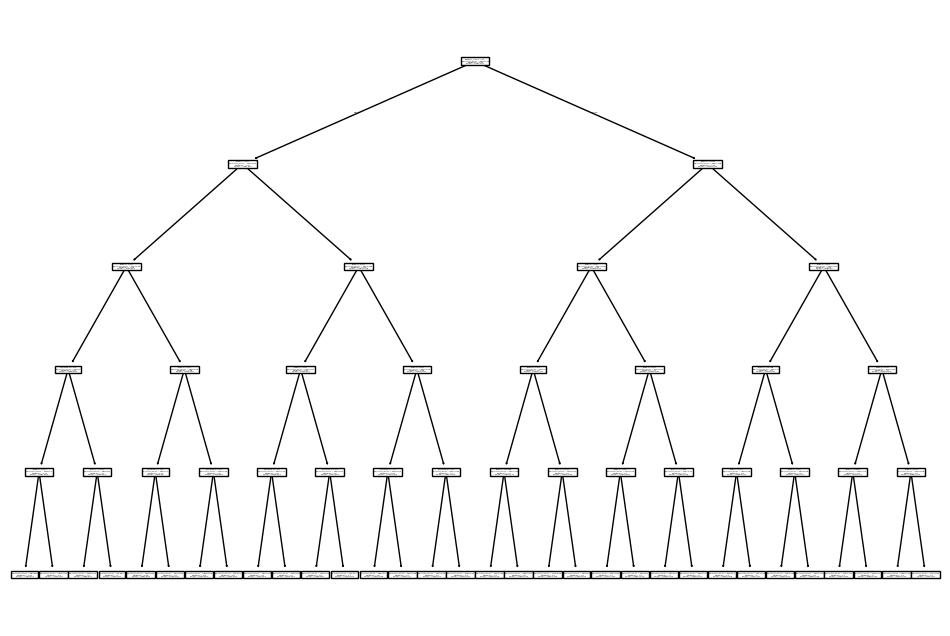

In [16]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(grid.best_estimator_, feature_names=X_train.columns)
plt.show()

Visualized the final, pruned decision tree structure.

In [17]:
importance = pd.DataFrame({'Feature': X.columns,
                            'Importance': grid.best_estimator_.feature_importances_}).sort_values(by='Importance', ascending=False)

print(importance)

            Feature  Importance
4        smoker_yes    0.426940
0               age    0.355615
1               bmi    0.196727
2          children    0.020717
3          sex_male    0.000000
5  region_northwest    0.000000
6  region_southeast    0.000000
7  region_southwest    0.000000


Ranked features by their importance in the final model's decision-making.

This model was the best model we built